<div style="background-color: black; color: white; padding: 10px;text-align: center;">
  <strong>Date Published:</strong> February 03, 2025 <strong>Author:</strong> Adnan Alaref
</div>

>**📝 Note: Multi-class classification problem deals with classifying something from a list of more than two options (e.g. classifying a photo as a cat a dog or a chicken).We will impelement PyTorch workflow in in the image below with multi-class classification task.**

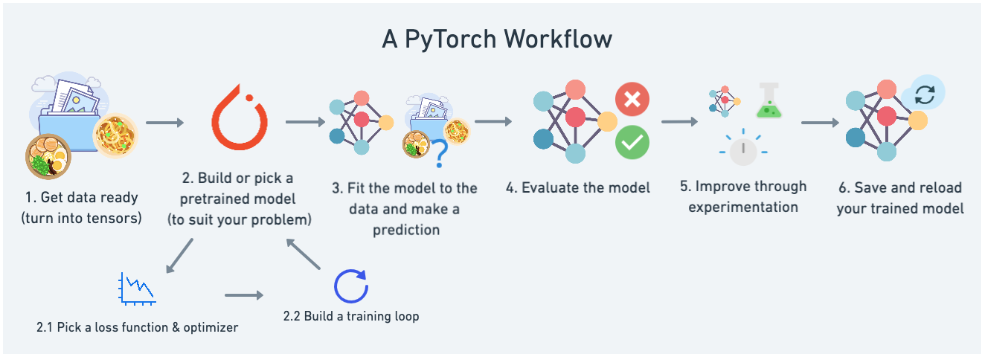

# **◍ Step 1: Import Required Librares.**

In [1]:
import torch
import numpy as np
import pandas as pd

from torch import nn
import seaborn as sns
from torch import optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split

import warnings
# Ignore all warnings
warnings.filterwarnings('ignore')
# Ignore all FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

# **◍ Step 2: Prepare the Dataset.**

**📝 Note: The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment but still sizeable enough to practice the fundamentals.**

## **🔸 Step 2.1: Create Blobs.**

In [2]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blobs ,y_blobs = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                                                centers=NUM_CLASSES,
                                                              cluster_std=1.5,
                                                                    random_state=RANDOM_SEED)
X_blobs[:5] ,y_blobs[:5]

(array([[-8.41339595,  6.93516545],
        [-5.76648413, -6.43117072],
        [-6.04213682, -6.76610151],
        [ 3.95083749,  0.69840313],
        [ 4.25049181, -0.28154475]]),
 array([3, 2, 2, 1, 1]))

In [3]:
print(X_blobs.shape) # X: ndarray of shape (n_samples, n_features)
print(y_blobs.shape) # y: ndarray of shape (n_samples,)

(1000, 2)
(1000,)


## **🔸 Step 2.2: Let's Visulaize**

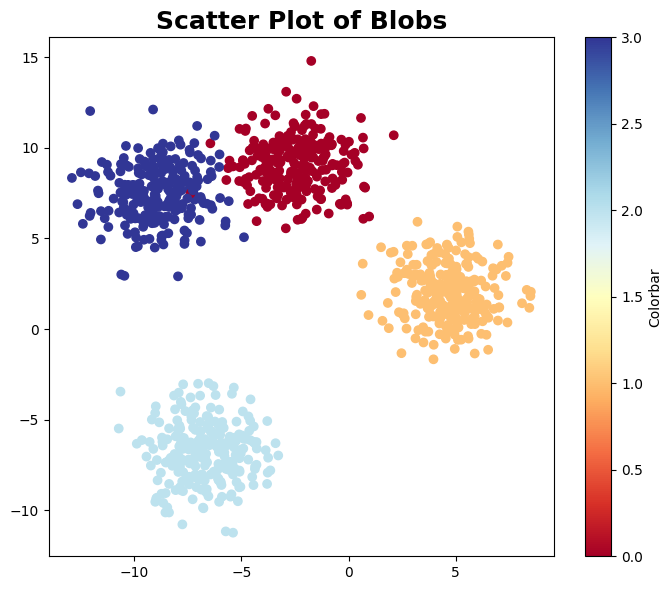

In [4]:
plt.figure(figsize = (7,6) ,dpi=100)
graph = plt.scatter(X_blobs[:,0],
                    X_blobs[:,1] ,
                    c=y_blobs ,
                    cmap = plt.cm.RdYlBu)
# Add colorbar to show the mapping of values to colors
plt.colorbar(graph ,label = "Colorbar")

# Add labels and title for better understanding
# plt.xlabel('X1' ,fontsize = 14 ,fontweight = 'bold')
# plt.ylabel('X2' ,fontsize = 14 ,fontweight = 'bold')
plt.title('Scatter Plot of Blobs' ,fontsize = 18 ,fontweight = 'bold')

# Display the plot
plt.tight_layout()
plt.show()

## **🔸 Step 2.3: Turn Data Into Tensors.**
>**Note:** **There are two ways to do that `torch.from_numpy` & ` torch.tensor`.**  

**Differences Between torch.tensor and torch.from_numpy**

**Copy Behavior:**  
* **torch.from_numpy:** Shares memory with the original NumPy array. Changes in one affect the other.  
* **torch.tensor:** Creates a new tensor with a copy of the data. The resulting tensor is independent of the NumPy array.

**Flexibility:**
* **torch.tensor** allows you to **specify additional options** like `dtype` and `device` directly during the conversion:  
```tensor = torch.tensor(numpy_array, dtype=torch.float32, device='cuda')```


**Use Case:**  
* **Use torch.from_numpy** when you want to share memory between the NumPy array and the tensor.  
* **Use torch.tensor** when you need a new independent tensor or need to specify properties like dtype or device.

In [5]:
# Convert to PyTorch tensors
X_blobs_tensor = torch.from_numpy(X_blobs).type(torch.float)
'''
!!! Note
The performance of this criterion is generally better when target contains class indices, as this allows for optimized computation.
Consider providing target as class probabilities only when a single class label per minibatch item is too restrictive.
So we will make type of target is Long to avoid this Runtime Error.
RuntimeError: expected scalar type Long but found Float
'''
y_blobs_tensor = torch.from_numpy(y_blobs).type(torch.long)

X_blobs_tensor[:5] ,y_blobs_tensor[:5]

(tensor([[-8.4134,  6.9352],
         [-5.7665, -6.4312],
         [-6.0421, -6.7661],
         [ 3.9508,  0.6984],
         [ 4.2505, -0.2815]]),
 tensor([3, 2, 2, 1, 1]))

In [6]:
type(X_blobs_tensor) ,type(y_blobs_tensor)

(torch.Tensor, torch.Tensor)

## **🔸 Step 2.4: Split the dataset into training and testing sets.**

In [7]:
X_train ,X_test ,y_train ,y_test = train_test_split(X_blobs_tensor ,y_blobs_tensor , test_size=0.2 ,random_state = 42)
len(X_train) ,len(X_test) ,len(y_train) ,len(y_test)

(800, 200, 800, 200)

In [8]:
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test : {X_test.shape}")
print(f"y_test : {y_test.shape}")
type(X_train) ,type(X_test) ,type(y_train) ,type(y_test)

X_train: torch.Size([800, 2])
y_train: torch.Size([800])
X_test : torch.Size([200, 2])
y_test : torch.Size([200])


(torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor)

# **◍ Step 3: Define the Model.**
**Let's build a model to classify blobs.**

* Setup device agonistic code so our code will run on an accelerator (GPU).
* Construct a model (by subclassing nn.Module)
* Define a loss function and optimizer
* Create a training and test loop

In [9]:
# 1. Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [10]:
''' Model ->-> In_features = 2 , out_features = 4 '''
X_blobs_tensor.shape ,torch.unique(y_blobs_tensor)

(torch.Size([1000, 2]), tensor([0, 1, 2, 3]))

In [11]:
# 2.Build multi class classification model
class BlobModel_v1(nn.Module):
  def __init__(self ,input_dim ,hidden_dim ,output_dim):
    super(BlobModel_v1 ,self).__init__()
    self.layers_stack = nn.Sequential(
        nn.Linear(in_features=input_dim ,out_features=hidden_dim),
        nn.ReLU(),
        nn.Linear(in_features=hidden_dim ,out_features=hidden_dim),
        nn.ReLU(),
        nn.Linear(in_features=hidden_dim ,out_features=output_dim)
    )

  # 3.Declare Forward function to define the computation in the model
  def forward(self ,x):
    return self.layers_stack(x)

# Hyperparameters
input_dim = 2 # Number of features in the dataset
hidden_dim = 10 # Number of neurons in the hidden layer
output_dim = 4 # Number of classes in the dataset

# 4.# Instantiate the model and send it to the target device
Blob_Model = BlobModel_v1(input_dim ,hidden_dim ,output_dim).to(device)
Blob_Model

BlobModel_v1(
  (layers_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=4, bias=True)
  )
)

In [12]:
next(Blob_Model.parameters()).device

device(type='cuda', index=0)

In [13]:
Blob_Model.state_dict()

OrderedDict([('layers_stack.0.weight',
              tensor([[-0.1301, -0.0097],
                      [-0.5464,  0.4584],
                      [-0.4669, -0.2323],
                      [ 0.0058,  0.2207],
                      [ 0.3095,  0.4803],
                      [ 0.1393,  0.6520],
                      [ 0.4782,  0.4765],
                      [-0.2258,  0.4205],
                      [ 0.3899, -0.6735],
                      [ 0.0222, -0.3119]], device='cuda:0')),
             ('layers_stack.0.bias',
              tensor([ 0.5734,  0.4474, -0.1533,  0.0061, -0.3520,  0.0417, -0.3780, -0.6852,
                       0.5598, -0.6113], device='cuda:0')),
             ('layers_stack.2.weight',
              tensor([[-0.2018,  0.3048,  0.1379,  0.1363,  0.1905,  0.1835,  0.2716, -0.1012,
                        0.1335, -0.1409],
                      [-0.1126, -0.2450, -0.0869,  0.2933,  0.0210,  0.1047,  0.0275,  0.1088,
                       -0.1241, -0.1259],
                 

## **🔸 Step 3.1: Setup Loss Function and Optimizer.**
**!!! Note:**   
>Recall a loss function (loss criterion or criterion) is what measures how wrong your model predictions are, the higher the loss, the worse your model.   
For classification you might want binary cross entropy or categorical cross entropy (cross entropy).

**Our Problem is Multi-class classification task so**: [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) - [NLLLoss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss)

  * **CrossEntropyLoss:**

   - **Use Case:** The most commonly used loss function for multi-class classification.
   - **Input:** Raw logits (unnormalized scores) from the model.
   - **Output:** A scalar loss value.
   - **How It Works:**
      * Combines LogSoftmax and NLLLoss (Negative Log Likelihood Loss) in one function.
      * Applies the softmax function to the logits to convert them into probabilities.
      * Computes the negative log likelihood of the correct class.
   - **Formula:**
   $$
    \text{Loss} = -\log\left(\frac{\exp(\text{logits}[y])}{\sum_j \exp(\text{logits}[j])}\right)
   $$
          where y is the true class label.

        ```python
    python
        criterion = nn.CrossEntropyLoss() # Using CrossEntropyLoss (directly with logits)                            
        outputs = model(inputs)  # Shape: (batch_size, num_classes)
        labels = torch.tensor([0, 2, 1])  # Shape: (batch_size,)
        loss = criterion(outputs, labels)
         ```
  * **NLLLoss (Negative Log Likelihood Loss):**
   - **Use Case:** Used when the model outputs log probabilities (e.g., after **LogSoftmax**).
   - **Input:** Log probabilities (output of **LogSoftmax**).
   - **Output:** A scalar loss value.
   - **How It Works:**
      * Computes the negative log likelihood of the correct class.
   - **Formula:**
   $$
    \text{NLL} = -\frac{1}{N} \sum_{i=1}^N \sum_{c=1}^C y_{i,c} \log(\hat{y}_{i,c})
   $$
         where y is the true class label.

        ```python
    python
        criterion = nn.NLLLoss() # Using NLLLoss (requires log probabilities)
        log_probs = F.log_softmax(outputs, dim=1) # Shape:(batch_size, num_classes) -Convert logits to log probabilities
        labels = torch.tensor([0, 2, 1])  # Shape: (batch_size,)
        loss = criterion(log_probs, labels)
         ```


<div align="center" style="font-size: 20px;">
Summary of Loss Functions

| Loss Function        | Use Case          | Input Type        | Output Type  |
|----------------------|--------------------------------------|------------------|-------------|
| **CrossEntropyLoss** | Multi-class classification          | Logits           | Scalar loss |
| **NLLLoss**         | Multi-class classification          | Log probabilities | Scalar loss |
| **BCEWithLogitsLoss** | Multi-label classification         | Logits           | Scalar loss |
| **KLDivLoss**       | Comparing probability distributions | Log probabilities | Scalar loss |
| **MultiMarginLoss** | Margin-based multi-class classification | Logits           | Scalar loss |

</div>

In [14]:
# Setup loss function
criterion = nn.CrossEntropyLoss()

# Setup optimizer
optimizer = optim.AdamW(Blob_Model.parameters() ,lr = 0.1 ,weight_decay = 1e-4)

## **🔸 Step 3.2: Getting prediction probabilities for a multi-class PyTorch model**
    In order to evaluate and train and test our model, we need to convert our model's outputs (logtis) to predicition probabilities and
    then to prediction labels.
    Logits (raw output of the model) -> Pred probs (use torch.softmax) -> Pred labels (take the argmax of the prediction probabilities)

**Find some logits**

In [15]:
Blob_Model.eval()
with torch.inference_mode():
  logits = Blob_Model(X_test.to(device))

logits[:5]

tensor([[ 0.5344, -0.1891, -0.3578, -0.4178],
        [ 0.9550,  0.8705, -0.4046, -1.2979],
        [ 0.4421, -0.2817, -0.0330, -0.0118],
        [ 0.2706, -0.3152, -0.0865, -0.0838],
        [ 1.0423,  0.7100, -0.6994, -1.5297]], device='cuda:0')

**From logits to propabilites using softmax.**

In [16]:
# Convert our model's logit outputs to prediction probabilities
preds_probs = torch.softmax(logits ,dim=1)
preds_probs[:5]

tensor([[0.4385, 0.2127, 0.1797, 0.1692],
        [0.4384, 0.4029, 0.1126, 0.0461],
        [0.3647, 0.1769, 0.2268, 0.2317],
        [0.3381, 0.1882, 0.2365, 0.2372],
        [0.5079, 0.3643, 0.0890, 0.0388]], device='cuda:0')

In [17]:
# As we see sum of row logits = 1.0
sum([0.3395, 0.2452, 0.1947, 0.2206])

1.0

**Get labels from probabilites using argmax function.**

In [18]:
# Convert our model's prediction probabilities to prediction labels
preds_labels = torch.argmax(preds_probs,dim=1)
preds_labels[:5]

tensor([0, 0, 0, 0, 0], device='cuda:0')

**In Full (logits -> pred probs -> pred labels)**

In [19]:
labels = torch.argmax(torch.softmax(logits[:5],dim=1),dim=1)
labels

tensor([0, 0, 0, 0, 0], device='cuda:0')

**Build Accuracy Function.**

In [20]:
def accuracy_fun(y_true ,y_preds):
  # toall_correct / total_samples
  total_corect = torch.eq(y_true ,y_preds).sum().item() # torch.eq() calculates where two tensors are equal
  acc = (total_corect / len(y_preds)) *100
  return acc

## **🔸 Step 3.3: Build traning and testing Loop.**

In [21]:
# Set Seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Track model values
epochs_count = []
test_loss_values = []
train_loss_values = []

# Put data in target device
X_train ,y_train = X_train.to(device) ,y_train.to(device)
X_test ,y_test = X_test.to(device) ,y_test.to(device)

# Hyperparameters
epochs = 100

### Training
for epoch in range(epochs):
  # Put Model in train mode
  Blob_Model.train()

  # 1. Forward pass
  train_logits = Blob_Model(X_train)
  train_preds = torch.softmax(train_logits ,dim=1).argmax(dim=1) # train-preds-labels

  # 2. Calculate loss
  train_loss = criterion(train_logits ,y_train) # criterion(Input ,target)
  # Calculate train accuracy(y_true ,y_pred(logits -> propabilites -> labels))
  train_acc = accuracy_fun(y_train ,train_preds)

  # 3. optimizer zero_grad
  optimizer.zero_grad()

  # 4. Do backprobagation
  train_loss.backward()

  # 5. optimizer step (gradent descent)
  optimizer.step()

  ### Testing
  # Set model in testing mode
  Blob_Model.eval()
  with torch.inference_mode():
    # Foreward pass
    test_logits = Blob_Model(X_test)
    test_preds = torch.argmax(torch.softmax(test_logits ,dim=1) ,dim=1) # test-preds-labels

    # Clacuate loss
    test_loss = criterion(test_logits ,y_test) # criterion(Input ,target)
    # Calculate train accuracy(y_true ,y_pred(logits -> propabilites -> labels))
    test_acc = accuracy_fun(y_test ,test_preds)

  # Show resultes per epoch
  if epoch % 10 == 0:
    epochs_count.append(epoch)

    # !!! Note: Convert from tensor to numpy array ,use directly tensor.cpu().numpy(),Not requires gradents because calculate in torch.inference_mode()
    test_loss_values.append(test_loss.cpu().numpy())

    # !!! Note: Convert from tensor to numpy array,use directly tensor.detach().cpu().numpy(),requires gradents because not calculate in torch.inference_mode()
    train_loss_values.append(train_loss.detach().cpu().numpy())

    print(f"Epoch: [{epoch+1}/{epochs}] - Train Accuracy: {train_acc:.3f}% - Train Loss: {train_loss:.3f} - Test Accuracy: {test_acc:.3f}% - Test Loss: {test_loss:.3f}")

Epoch: [1/100] - Train Accuracy: 22.125% - Train Loss: 1.765 - Test Accuracy: 32.000% - Test Loss: 1.158
Epoch: [11/100] - Train Accuracy: 99.250% - Train Loss: 0.032 - Test Accuracy: 99.500% - Test Loss: 0.011
Epoch: [21/100] - Train Accuracy: 99.250% - Train Loss: 0.033 - Test Accuracy: 99.500% - Test Loss: 0.006
Epoch: [31/100] - Train Accuracy: 99.250% - Train Loss: 0.027 - Test Accuracy: 99.500% - Test Loss: 0.032
Epoch: [41/100] - Train Accuracy: 99.250% - Train Loss: 0.027 - Test Accuracy: 99.500% - Test Loss: 0.006
Epoch: [51/100] - Train Accuracy: 99.125% - Train Loss: 0.023 - Test Accuracy: 99.500% - Test Loss: 0.008
Epoch: [61/100] - Train Accuracy: 99.375% - Train Loss: 0.020 - Test Accuracy: 100.000% - Test Loss: 0.007
Epoch: [71/100] - Train Accuracy: 99.500% - Train Loss: 0.019 - Test Accuracy: 100.000% - Test Loss: 0.007
Epoch: [81/100] - Train Accuracy: 99.500% - Train Loss: 0.018 - Test Accuracy: 100.000% - Test Loss: 0.006
Epoch: [91/100] - Train Accuracy: 99.500% - 

**🔍 Key Difference:**

| Expression                        | Requires Gradients?   | Works Without `inference_mode()`?             | Safe to Use Always                      |
|------------------------------------|-----------------------|-----------------------------------------------|-----------------------------------------|
| `tensor.cpu().numpy()`          | ❌ No                 | ❌ No (will error if gradients exist)         | ✅ Yes, if computed in `inference_mode` |
| `tensor.detach().cpu().numpy()` | ✅ Yes or ❌ No        | ✅ Yes (always safe)                          | ✅ Yes (best for general use)           |


**🚀 Conclusion:**
  * If you always use torch.inference_mode(), **.cpu().numpy()** is sufficient.
  * If you're unsure or running outside inference mode, always use **.detach().cpu().numpy()** to prevent gradient-related errors.

## **🔸 Step 3.4: Let's Visualize our model.**
📝 **Note:** we will use function `plot_decision_boundary()` this function had implemented by **Daniel Bourke** [helper_functions.py](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py)

In [22]:
import requests
from pathlib import Path

# Downloding helper function from git hub repo.
if Path("helper_function.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_function.py" ,'wb') as f:
    f.write(request.content)

**Define some visualization functions.**

📝 **Note:** In Function **plot_decision_boundary**
* Behidn the seen we put everything to CPU (works better with NumPy + Matplotlib).
* We put `model.cpu()` ,`X_data.cpu()` and `y_data.cpu()` to avoid errors because **Matplotlib** work only with **CPU** not work with **GPU**.

In [23]:
def Display_Dcision_Boundary(Model ,X_train ,X_test ,y_train ,y_test):
  from helper_function import plot_predictions , plot_decision_boundary

  # Make figure
  plt.figure(figsize = (10,5) ,dpi = 100)

  # Plot train set
  plt.subplot(1,2,1)
  plt.title("Traning set" ,fontsize = 15 ,fontweight = 'bold')
  plot_decision_boundary(Model ,X_train ,y_train)

  # Plot test set
  plt.subplot(1,2,2)
  plt.title("Testing set" ,fontsize = 15 ,fontweight = 'bold')
  plot_decision_boundary(Model ,X_test ,y_test)

  plt.tight_layout()
  plt.show()

In [24]:
# Make Some prediction to diplay Confusion Matrix
def Find_Predictions(Model ,X_test):
  Model.to(device)
  Model.eval()
  with torch.inference_mode():
    logits = Model(X_test.to(device))
    y_probs = torch.softmax(logits ,dim=1) # probapilites
    y_preds = torch.softmax(logits,dim=1).argmax(dim=1) # labels
  return y_preds ,y_probs

In [25]:
def Display_confusion_matrix(Model ,X_test ,y_test):
  # Find predictions
  y_pred ,_ = Find_Predictions(Model ,X_test)
  Conf_matrix  = confusion_matrix(y_test.cpu().numpy() ,y_pred.cpu().numpy())

  # Plot Heatmap
  plt.figure(figsize = (6,5) ,dpi = 100)
  sns.heatmap(Conf_matrix ,cmap=plt.cm.Blues ,annot=True ,fmt='d')
  plt.title("Confunsion Matrix" ,fontsize = 15 ,fontweight = 'bold')
  plt.xlabel('Predicted' ,fontsize = 12 ,fontweight = 'bold')
  plt.ylabel('Actual' ,fontsize = 12 ,fontweight = 'bold')
  plt.tight_layout()
  plt.show()

In [26]:
# Display Classification report
def Display_Classification_Report(Model ,X_test ,y_test):
  y_preds ,_ = Find_Predictions(Model ,X_test)
  report = classification_report(y_test.cpu().numpy() ,y_preds.cpu().numpy(),target_names=["Class 0" ,"Class 1","Class 2","Class 3"])
  print(f"Classification Report:\n{report}")

In [27]:
def Display_train_test_loss_curves(epochs_count ,train_losses ,test_losses ,Model_name):
  plt.figure(figsize=(6,5) ,dpi=100)
  plt.plot(epochs_count ,train_losses ,c = 'b' ,label = "Train Loss")
  plt.plot(epochs_count ,test_losses ,c = 'r' ,label = "Test Loss")
  plt.ylabel("Loss" ,fontsize = 12 ,weight='bold')
  plt.xlabel("Epochs" ,fontsize = 12 ,weight='bold')
  plt.title(f"Traning and Testing Loss Curves/{Model_name}" ,fontsize = 12 ,weight='bold')
  plt.legend(prop = {"size":14},loc = "upper right")

  plt.tight_layout()
  plt.show()

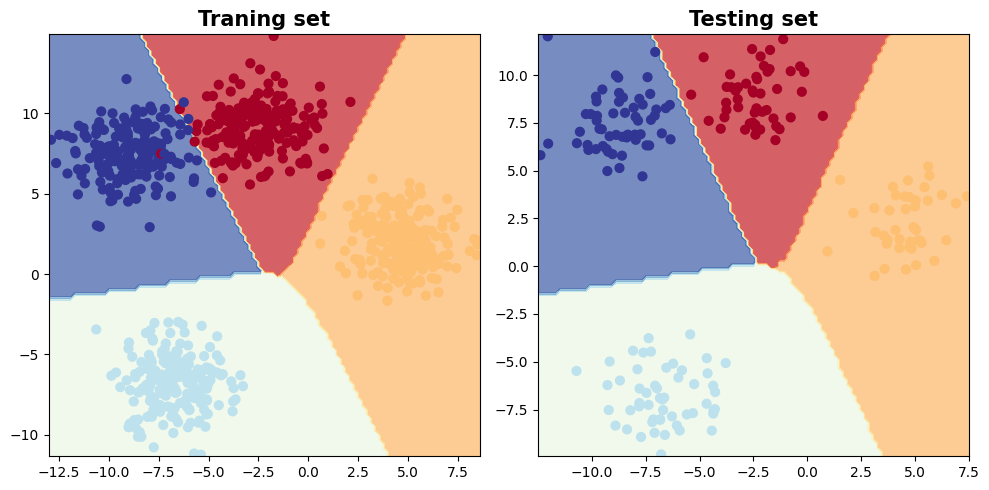

In [28]:
Display_Dcision_Boundary(Blob_Model ,X_train ,X_test ,y_train ,y_test)

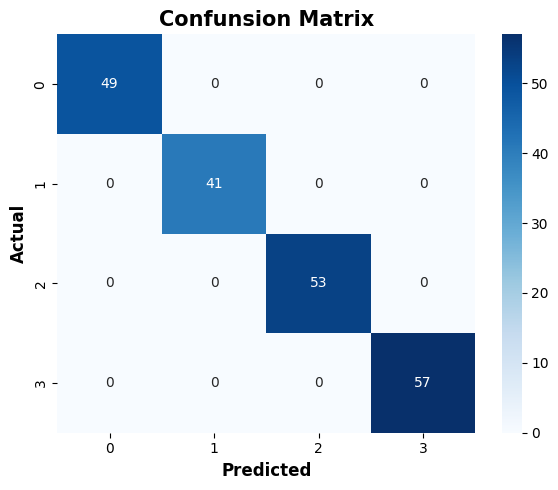

In [29]:
Display_confusion_matrix(Blob_Model ,X_test ,y_test)

In [30]:
Display_Classification_Report(Blob_Model ,X_test ,y_test)

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        49
     Class 1       1.00      1.00      1.00        41
     Class 2       1.00      1.00      1.00        53
     Class 3       1.00      1.00      1.00        57

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



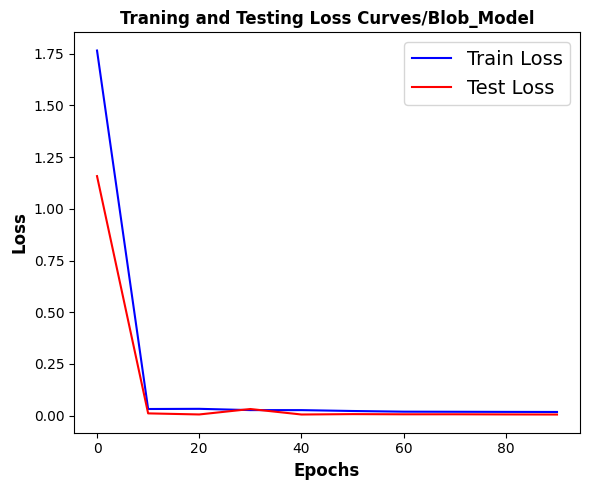

In [31]:
Display_train_test_loss_curves(epochs_count ,train_loss_values ,test_loss_values ,"Blob_Model")

# **◍ Step 4: Let's get to know some evaluation metrics.**

In [32]:
%%capture
! pip install torchmetrics

**!!! Note:** Accurcy function in PyTorch need task and num_classes ,without
them will return error.  
❌ <span style="color: red;">TypeError: Accuracy.__new__() missing 1 required positional argument: 'task' and 'num_classes'!</span>
```python
python
# Example: For binary classification
acc_score = Accuracy(task="binary").to(device)

# Example: For multiclass classification
acc_score = Accuracy(task="multiclass", num_classes=10).to(device)

# Example: For multilabel classification
acc_score = Accuracy(task="multilabel", num_labels=5).to(device)
```

In [33]:
from torchmetrics import Accuracy, Precision ,Recall ,F1Score ,ConfusionMatrix

# Find predictions
y_prd ,_ = Find_Predictions(Blob_Model ,X_test)

# Setup metric
acc_score = Accuracy(task="multiclass", num_classes=4).to(device)

# Calculuate accuracy
acc_score(y_prd ,y_test)

tensor(1., device='cuda:0')

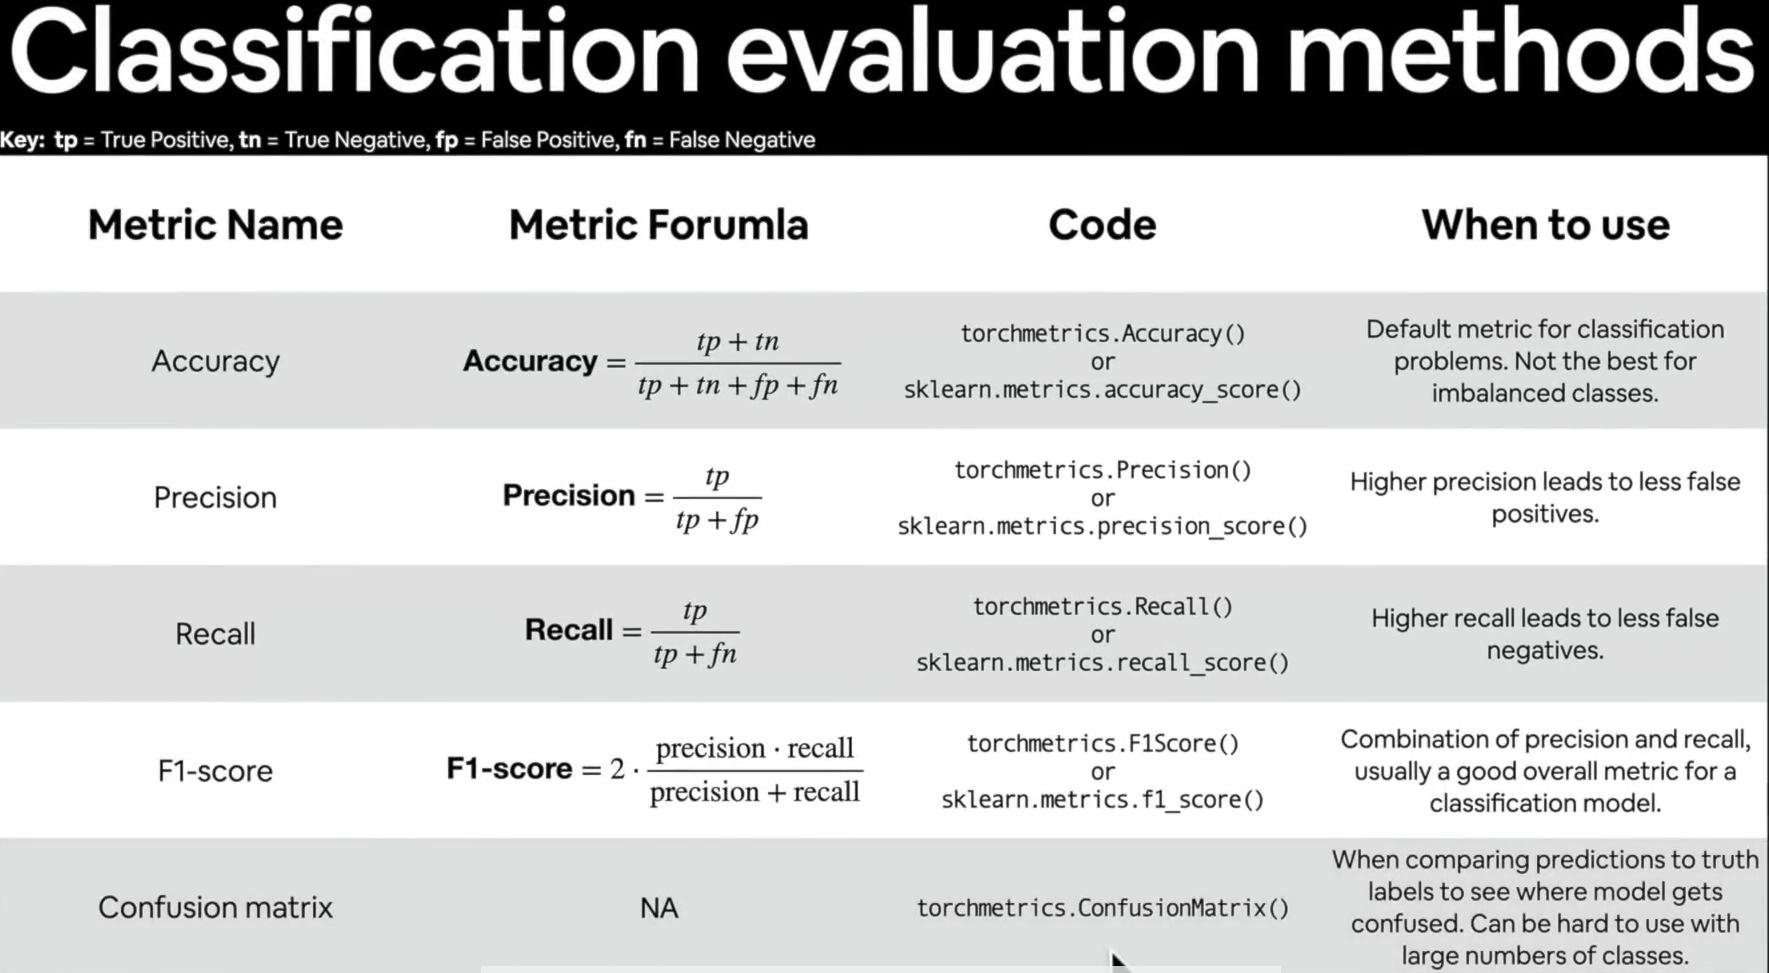

<a id="Import"></a>
<p style="background-color: #000000; font-family: 'Verdana', sans-serif; color: #FFFFFF; font-size: 160%; text-align: center; border-radius: 25px; padding: 12px 20px; margin-top: 20px; border: 2px solid transparent; background-image: linear-gradient(black, black), linear-gradient(45deg, #FF00FF, #00FFFF, #FFFF00, #FF4500); background-origin: border-box; background-clip: content-box, border-box; box-shadow: 0px 4px 20px rgba(255, 105, 180, 0.8);">
   Thanks & Upvote ❤️</p>